# RC3. Recommendation de contenus

L'objectif de ce projet est de créer un outil de recommendation de contenus: pour un utilisateur qui indique ses préférences (notes ou like) sur des contenus (films, musiques, jeux vidéos…), vous lui recommanderez des contenus similaires, découvert automatiquement à partir des préférences des autres utilisateurs (en se basant sur des bases de données existantes). Vous pouvez travailler uniquement sur l'algorithme lui-même (python uniquement donc), ou faire un site web complet de recommendation. Un exemple de méthode classique pour le faire est le collaborative filtering: https://en.wikipedia.org/wiki/Collaborative_filtering , mais d'autres méthodes plus avancées seront possible pour les groupes qui avancent rapidement. 

mes sources de documentations: 
https://github.com/Yquetzal/Teaching_notebooks/blob/main/Networks/Movie-similarity.ipynb

https://en.wikipedia.org/wiki/Collaborative_filtering

https://pandas.pydata.org/pandas-docs/stable/index.html

super Doc: http://www.metz.supelec.fr/metz/personnel/pennerath/Cours/DataScience/5-Systemes%20de%20recommandation.pdf

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import warnings
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA as pc
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from analyseAllan import genresVal
#from analysePE import chargeDonneDossier

pour la base de données trop grosse pour git:

https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset

https://www.kaggle.com/datasets/grouplens/movielens-20m-dataset?select=movie.csv

https://www.kaggle.com/datasets/hernan4444/anime-recommendation-database-2020?select=rating_complete.csv

il nous faut une BD qui contient des avis utilisateurs
seul the-movies-dataset en small passait

In [2]:
# Protect execution
if __name__=='__main__':
    
    location = "../archive/the-movies-dataset/"

    credits = pd.read_csv(location+"credits.csv")
    #Contains Cast, Crew, ID 

    keywords = pd.read_csv(location+"keywords.csv")
    #Contains ID, keywords

    links_small = pd.read_csv(location+"links_small.csv")
    #Contains IMDB and TMDB IDs of all movies featured in the ratings_small.csv file (About 9000 movies).

    movies_metadata = pd.read_csv(location+"movies_metadata.csv", low_memory=False)
    #Contains adult, belongs_to_collection, budget, genres, homepage, id, imdb_id, original_language, original_title, overview
    # popularity, poster_path, production_companies, production_countries, release_date, revenue, runtime, spoken_languages, status
    # tagline, title, video, vote_average, vote_count

    clean = ["1997-08-20", "2012-09-29", "2014-01-01"]
    movies_metadata = movies_metadata[~movies_metadata['id'].isin(clean)]
    movies_metadata['id'] = movies_metadata['id'].apply(int)
    #c'est pas des entiers de base!!

    ratings_small = pd.read_csv(location+"ratings_small.csv")
    #Contains userId, movieId, rating, timestamp

In [3]:
#movies_metadata

plusieur fonction s'impose j'ai besoin de :

        idFromUserRating : récup une liste de film A en fonction d'un userID, minimumRating
        
        userFromMovies :récup une liste d'utilisateur en fonction de cette précedente liste de film A, et du 
        minimumRating
        
        récup une liste de film B que les utilisateurs on évaluer au dessus de minimumRating et qui ne sont pas 
        dans la liste de film A 

In [4]:
def idFromUserRating(userID, minRating, ratings_small):
    filtre0 = ratings_small[ratings_small['userId'].eq(userID)]
    filtre1 = filtre0["movieId"].where(filtre0.rating >= minRating).dropna()
    return list(filtre1)
#idFromUserRating(2,0,ratings_small)

In [5]:
def userFromMovies(Movies,minRating, ratings_small):
    filtre0 = ratings_small[ratings_small['movieId'].isin(Movies)]
    filtre1 = filtre0["userId"].where(filtre0.rating >= minRating).dropna()
    return sorted(list(set(filtre1)))
#userFromMovies(idFromUserRating(1,4,ratings_small),4, ratings_small)

In [6]:
def recoMovies(Users, Movies, minRating, ratings_small):
    filtre0 = ratings_small[~ratings_small['movieId'].isin(Movies)]
    filtre1 = filtre0.where(filtre0.rating >= minRating).dropna()
    filtre2 = filtre1[filtre1['userId'].isin(Users)]
    return sorted(list(set(filtre2["movieId"])))

In [7]:
def infoFromId(Movies, movies_metadata, links_small):
    tmdbId = list()
    fltr = links_small[links_small['movieId'].isin(Movies)]
    tmdbId = fltr['tmdbId']
    return movies_metadata[movies_metadata['id'].isin(tmdbId)]

In [8]:
# Protect execution
if __name__=='__main__':
    mr = 4
    grpMovie = idFromUserRating(1, mr, ratings_small)
    grpUser = userFromMovies(grpMovie, mr, ratings_small)
    grpReco1 = recoMovies(grpUser,grpMovie, mr, ratings_small)
    infoFromId(grpReco1, movies_metadata, links_small)

# Amélioration évidente

Grâce à la super doc:http://www.metz.supelec.fr/metz/personnel/pennerath/Cours/DataScience/5-Systemes%20de%20recommandation.pdf

Je vais construire une matrice des recommendations en fonction des users et des films afin de créer une fonction de similarité pour les utilisateurs

avec la similarité et les notes je vais pouvoir construire une spéculation de la note pour le film i et l'utilisateur j qui ne la pas vu


In [9]:
#attention très lent à executer que si necessaire   
def simCalc(Ui, Ucible):
    Ui_vec = np.array(matReco.loc[Ui])
    Ucible_vec = np.array(matReco.loc[Ucible])
    num = np.dot(Ui_vec, Ucible_vec)
    denom1 = np.linalg.norm(Ui_vec)**2
    denom2 = np.linalg.norm(Ucible_vec)**2
    res = num/(np.sqrt(denom1)*np.sqrt(denom2))
    return res

def imputerData(base, strat):
    imputer = SimpleImputer(strategy=strat)
    return pd.DataFrame(imputer.fit_transform(base))

def tabSim(matReco):
    #similaire mais plus lent
    #for u1 in userList:
     #   for u2 in userList:
      #      matSim[u1][u2]=simCalc(u2, u1)
       # matSim[matSim <= minSim] = 0
    matSim = cosine_similarity(matReco.to_numpy())
    return matSim
# Protect execution
if __name__=='__main__':
    matReco = ratings_small.pivot(index='userId', columns='movieId', values='rating')
    userList=list(matReco.index)
    matSim=pd.DataFrame(index=userList, columns=userList)
    matSim = tabSim(imputerData(matReco,'mean'))
    matSim

In [10]:
def RecoParSim(Ui, Movie, matReco):
    matReco_imputed=imputerData(matReco,'mean')
    matReco=matReco.fillna(-1)
    Ui_vecS = list()
    for i in range(len(matReco_imputed)):
        if i+1 == Ui:
            Ui_vecS.append(0)
        elif matReco[Movie][i+1] != -1:
            Ui_vecS.append(matSim[Ui-1][i])
            #print(matSim[Ui][i])
        else:
            Ui_vecS.append(0)
    denom = sum(Ui_vecS)
    Mov_vec = np.array(matReco[Movie])
    num = np.dot(Ui_vecS, Mov_vec)
    return num/denom;
# Protect execution
if __name__=='__main__':
    print(RecoParSim(671, 6269,matReco))
    matReco

4.168421516246085


Donc la maintenant faut que je test l'efficacité tu test par rapport à des notes que je connais déjà, supper test mais faut attendre au moins 3 minutes

In [11]:
def TestEfficacite(fct,matRec):
    vec = list()
    matNote=ratings_small.pivot(index='userId', columns='movieId', values='rating')
    for j in matRec.columns:
        for i in range(len(matRec)):
            if matNote[j][i+1] != np.nan:
                vec.append(np.abs(fct(i, j, matNote.fillna(-1))-matRec[j][i+1]))
    vec = [x for x in vec if not np.isnan(x)]
    print("l'erreur min: ",min(vec)," l'erreur max: ",max(vec))
    print("l'erreur moyenne: ",sum(vec)/len(vec))
#TestEfficacite(RecoParSim,matReco)

aller maintenant je veux visualiser mes groupes d'utilisateur pour en déterminer des profils

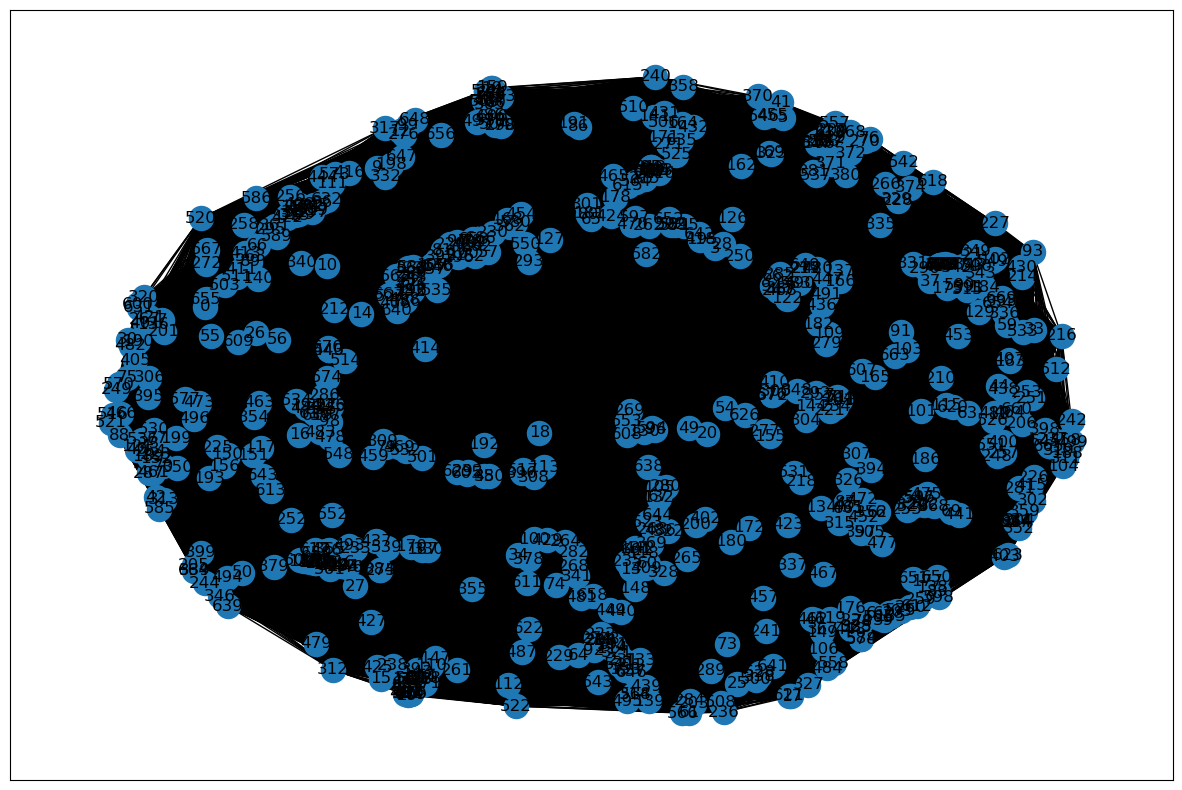

In [12]:
def visuGrpUser(matSimilarité, minSim):
    matSimcp = matSimilarité.copy()
    np.fill_diagonal(matSimcp,0)
    matSimcp[matSimcp <= minSim] = 0
    g = nx.from_numpy_matrix(matSimcp)
    #g = nx.relabel_nodes(g,{i:movieNames[i] for i in range(len(movieID))})
    plt.figure(2,figsize=(15,10)) 
    nx.draw_networkx(g)
# Protect execution
if __name__=='__main__':
    visuGrpUser(matSim,0.4)
    matSim

In [13]:
def recap (base, minPerte) :
    X = imputerData(base, 'mean')
    labels = base.index
    
    sklearn_pca = pc(n_components=len(matReco2)) 
    sklearn_transf = sklearn_pca.fit_transform(X)
    pourcentage = sklearn_pca.explained_variance_ratio_
    res = 0
    i=0
    res2vect = 0
    while res < minPerte:
        res += pourcentage[i]
        i += 1
        if(i == 2):
            res2vect = res
    print("pour conserver plus de ",minPerte,"% d'information il faut conserver ",i," vecteurs")
    if(i != 2):
        print("on conserve ",res2vect,"% d'information pour les 2 vecteurs du graphique")
    sklearn_pca = pc(n_components=i)
    sklearn_transf = sklearn_pca.fit_transform(X)
    plt.scatter(sklearn_transf[:, 0], sklearn_transf[:, 1])
    for l, x, y in zip(labels, sklearn_transf[:, 0], sklearn_transf[:, 1]):
        plt.annotate(l, xy=(x, y), xytext=(-0.2, 0.2), textcoords='offset points')
    plt.show()
#recap(matReco, 0.9)

du coup on voit ça veut rien dire, je veux récup mes groupes similaire par classification plate avec l'algo k-means

In [14]:
def methodeKmeans(X, q):
    model = KMeans(n_clusters=q, n_init=10).fit(X)
    Y_pred = model.predict(X)
    return Y_pred.tolist()
#methodeKmeans(matSim,3)

In [15]:
def UsePartition(listPartition,q):
    tabGrp = []
    for i in range(q):
        tabTmp = []
        index = 0
        for j in listPartition:
            if j==i:
                tabTmp.append(index)
            index += 1
        tabGrp.append(tabTmp)
    return tabGrp
# Protect execution
if __name__=='__main__':
    q=3
    listPartition = methodeKmeans(matSim,q)
    tabGrp = UsePartition(listPartition,q)

maintenant, on a un tableau qui contient q liste de groupe d'utilisateur rapproché par K-means, on va tenté de l'utiliser pour en resortir point commun, 

on va faire la fct PointCommun qui prend une Partition et un minimum rating, on sais déjà que les utilisateurs sont proche, on va juste sortir les film qui été évalué positivement pour in finé ressortir un potentiel point commun entre ces films

L'utilité de toutes ces fonctions est de comprendre ce qui différencie les groupes dans les fait, bientôt des fonction de comparaison pour mieux voir les points commun intra-groupe, et ainsi amélioré notre recommendation

un bon points commun est une caractéristique qui rapproche les utilisateur intra-groupe et qui éloigne les utilisateur inter-groupe

In [16]:
def PointCommun(Partition, minR, movies_metadata, links_small, ratings_small):
    filtre0 = ratings_small[ratings_small['userId'].isin(Partition)]
    filtre1 = filtre0["movieId"].where(filtre0.rating >= minR).dropna()
    return infoFromId(filtre1, movies_metadata, links_small)
# Protect execution
if __name__=='__main__':    
    BDInterpretable = []
    for i in range(q):
        BDInterpretable.append(PointCommun(tabGrp[i], 5, movies_metadata, links_small,ratings_small))


la fonction ComprendreBudget prend une BD. retourne une liste de aff,stats de la BD, et montre un diagramme en barre.

In [17]:
def ComprendreBudget(base):
    aff = base['budget'].apply(int)
    aff = aff[~aff.eq(0)]
    stats = aff.describe()
    means = stats[1]/1000000
    median = stats[5]/1000000
    aff = aff.apply(lambda x: x / 1000000) # Diviser toutes les valeurs par un million
    aff = aff.value_counts()
    print(aff)
    plt.bar(aff.index, aff.values)
    plt.ylabel("répartition des films")
    plt.xlabel("budget(en million)")
    plt.bar(means, max(aff), color='red')
    plt.bar(median, max(aff), color='green')
    plt.legend(['nombre de film', 'Moyenne','Medianne'], loc='upper right')
    plt.show()
    plt.savefig("../img/ComprendreBudget.png")
    return [aff,stats]
#ComprendreBudget(BDInterpretable[0]);

ComprendreLanguage prend une base et retourne base.value_counts(), il l'affiche aussi en diagramme de barre

In [18]:
def ComprendreLanguage(base):
    aff = base['original_language']
    aff = aff.value_counts()
    plt.bar(aff.index, aff)
    plt.xlabel("langues")
    plt.ylabel("répartition")
    return aff
#ComprendreLanguage(BDInterpretable[0]);

ComprendreDurée prend une base et retourne base.describe(), il affiche diagramme en bar des répartition des durée

In [19]:
def ComprendreDurée(base):
    aff = base['runtime'].apply(int)
    aff = aff[~aff.eq(0)]
    stats = aff.describe()
    #print(stats)
    aff = aff.value_counts()
    plt.bar(aff.index, aff)
    plt.xlabel("durée")
    plt.ylabel("répartition")
    return type(stats)
#ComprendreDurée(BDInterpretable[0])

C'est bien beau mais l'intéret est de comparer à la moyenne des groupes/index

15.000000    60
25.000000    57
30.000000    53
20.000000    49
10.000000    45
             ..
1.453000      1
0.011791      1
0.355000      1
0.291000      1
99.000000     1
Name: budget, Length: 371, dtype: int64


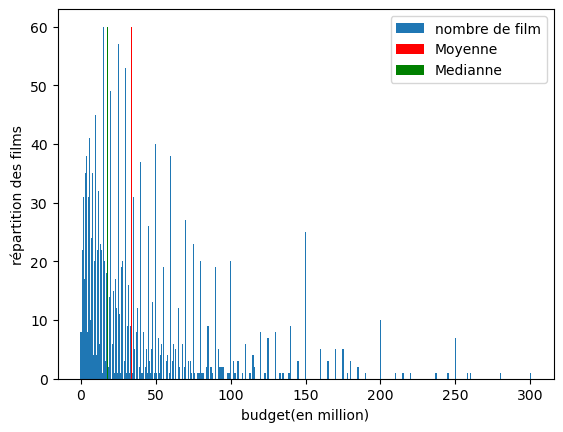

40.00     4
25.00     4
63.00     3
60.00     3
10.00     3
15.00     1
160.00    1
65.00     1
165.00    1
53.00     1
50.00     1
94.00     1
28.00     1
45.00     1
80.00     1
9.25      1
185.00    1
29.50     1
140.00    1
36.00     1
24.00     1
48.00     1
19.00     1
16.40     1
17.00     1
11.00     1
10.50     1
1.80      1
55.00     1
8.00      1
16.00     1
14.00     1
Name: budget, dtype: int64


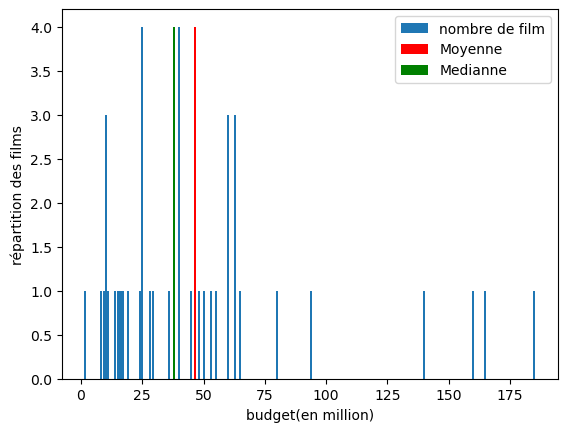

30.000000     18
6.000000      16
18.000000     13
15.000000     11
4.000000      10
              ..
6.400000       1
0.000120       1
27.000000      1
0.806948       1
280.000000     1
Name: budget, Length: 171, dtype: int64


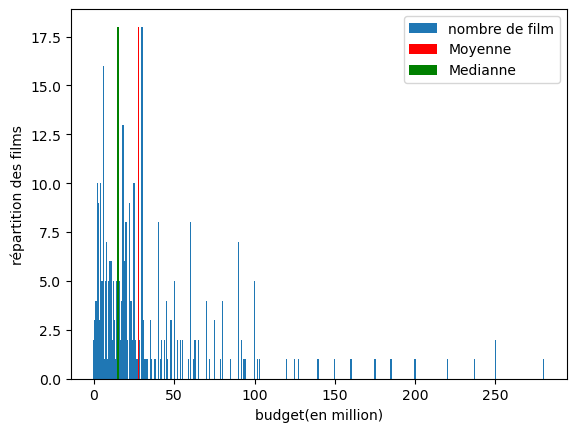

<Figure size 640x480 with 0 Axes>

In [20]:
def ComparaisonMeans(fct, listBd):
    listG = []
    for i in listBd:
        tmp = fct(i)
        listG.append(tmp[1][1])
        tmp[0]
    minimum=min(listG)
    maximum=max(listG)
    Imin = np.where( listG == minimum )
    Imax = np.where( listG == maximum )
    s = pd.Series([minimum, maximum, Imin[0], Imax[0]], index=['min', 'max', 'indice min', 'indice max'])
    return s
# Protect execution
if __name__=='__main__':
    s = ComparaisonMeans(ComprendreBudget,BDInterpretable)
    s

il me faut faire une recherche sur le genre, qui semble plus compliquée, car la BD contient une string de genre

In [21]:
def ComprendreGenre(base):
    vrakGenre = base['genres'][:]
    listGenre = []
    res = []
    for i in vrakGenre:
        listGenre += genresVal(i)
    listUniqueG = list(set(listGenre))
    print(listUniqueG)
    for j in listUniqueG:
        somme = 0
        for i in listGenre:
            if( i == j ):
                somme+=1
        res.append(somme)
    Serie = pd.Series(res, index=listUniqueG).sort_values(ascending=False)
    plt.xlabel("Genres")
    plt.ylabel("répartition")
    plt.bar(Serie.index, Serie)
    return Serie
#ComprendreGenre(movies_metadata, BDInterpretable[1])

#valeur du groupe - valeur moyenne / quantité de film
# normaliser
# faire des test statistique 
# seaborn hierarchique clustering

In [22]:
def ComparaisonGenre(listBd):
    listG = []
    for i in listBd:
        listG.append(ComprendreGenre(i))
#ComparaisonGenre(BDInterpretable)

tu es dans le groupe 1
['Thriller', 'History', 'Science-Fiction', 'Western', 'Animation', 'Music', 'Action', 'Drama', 'Fantasy', 'Documentary', 'TV-Movie', 'Comedy', 'Horror', 'Crime', 'Adventure', 'Romance', 'War', 'Mystery', 'Family', 'Foreign']
voici tes infos concernant ton groupe
 Drama              640
Comedy             340
Thriller           243
Action             225
Romance            211
Adventure          202
Crime              171
Science-Fiction    128
Family             114
Fantasy            102
Mystery             96
Animation           69
History             66
War                 60
Music               47
Horror              37
Documentary         23
Western             14
Foreign              8
TV-Movie             1
dtype: int64


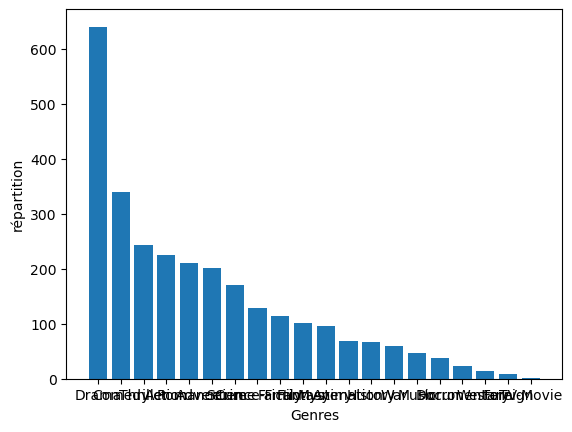

In [23]:
def StatUser(ID,fct,ratings_small,q,movies_metadata,links_small):
    matReco = ratings_small.pivot(index='userId', columns='movieId', values='rating')
    matReco = matReco.replace(np.NaN,0)
    userList=list(matReco.index)
    matSim=pd.DataFrame(index=userList, columns=userList)
    matSim = tabSim(matReco)
    
    listPartition = methodeKmeans(matSim,q)
    tabGrp = UsePartition(listPartition,q)
    
    BDInterpretable = []
    for i in range(q):
        BDInterpretable.append(PointCommun(tabGrp[i], 5, movies_metadata, links_small,ratings_small))
    
    c = 0
    for i in tabGrp:
        if ID in i:
            print("tu es dans le groupe",c)
            break
        c += 1
    print("voici tes infos concernant ton groupe\n",fct(BDInterpretable[c]))
# Protect execution
if __name__=='__main__':
    StatUser(23,ComprendreGenre,ratings_small,q,movies_metadata,links_small)

In [24]:
#pcR
#cocluestering 

# Conclusion

Je suis un peu déçu de la non perticence de mon analyse, Je vais recommencer tout dans un fichier nommé AnalyseData.ipynb Ce qui marque la fin de ma démarche de recherche m'ayant apprise plein de chose. Je reprend au calme et on implémenteras rapidement les choses de AnalyseData avec Arthur. Ce fichier n'est plus qu'un historique. Je suis un diesel mais je viens de mêtre la 4 ème.